In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Reading the data

In [2]:
df = pd.read_csv('data/OpenI/OpenI_cheXpertLabels.csv')
print("The total No. of rows:", len(df))
df.head()

The total No. of rows: 2452


,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Fracture,SupportDevices
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,['No Finding'],1,0,0,0,0,0,0,0,0,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,['No Finding'],1,0,0,0,0,0,0,0,0,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,['No Finding'],1,0,0,0,0,0,0,0,0,0,0
3,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,['No Finding'],1,0,0,0,0,0,0,0,0,0,0
4,1005,NaN,Pruritic.,Cardiac and mediastinal contours are within no...,No acute findings.,['No Finding'],1,0,0,0,0,0,0,0,0,0,0


In [3]:
print('No. of rows with Finding:', len(df[df['FINDINGS'].notnull()]))
print('No. of rows with Impression:', len(df[df['IMPRESSION'].notnull()]))
print('No. of rows with Impression or Finding:', 
      len(df[df['IMPRESSION'].notnull() | df['FINDINGS'].notnull()]))
print('No. of rows without Impression and Finding:', 
      len(df[df['IMPRESSION'].isna() & df['FINDINGS'].isna()]))

No. of rows with Finding: 2106
No. of rows with Impression: 2420
No. of rows with Impression or Finding: 2424
No. of rows without Impression and Finding: 28


In [4]:
idx = df[df['IMPRESSION'].isna() & df['FINDINGS'].isna()].index
df = df.drop(idx)
print('No. of rows without Impression and Finding:', 
      len(df[df['IMPRESSION'].isna() & df['FINDINGS'].isna()]))

No. of rows without Impression and Finding: 0


In [5]:
labels = ['No Finding', 'Cardiomegaly','Lung Opacity','Edema','Consolidation','Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion','Fracture','SupportDevices']

df_cls = pd.DataFrame(columns = ['text', 'labels'])

def concat_cols(impression, findings):
    if impression is np.nan:
        return findings
    elif findings is np.nan:
        return impression
    else:
        return findings+impression

# create the text column:
df_cls['text'] = df.apply(lambda row: concat_cols(row['IMPRESSION'], row['FINDINGS']), axis=1)
df_cls['labels'] = df.apply(lambda row: row[labels].to_list(), axis=1)

df_cls.head(10)

,text,labels
0,The lungs are without focal air space opacity....,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Heart size and mediastinal contour are normal....,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,The lungs are clear. Heart size is normal. No ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Cardiomediastinal silhouette is normal. Pulmon...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Cardiac and mediastinal contours are within no...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,Mediastinal contours are normal. Lungs are cle...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,Heart size and mediastinal contours are unrema...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,"The heart is again enlarged, stable. The left ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,Normal heart size. No focal air space consolid...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9,Heart size within normal limits. No focal airs...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# Splitting the data

In [6]:
# Using stratify
# trainX, valX, trainY, valY = train_test_split(df_cls['text'].values.tolist(), 
#                                               df_cls['labels'].values.tolist(), 
#                                               test_size=0.2,
#                                               stratify = df_cls['labels'].values.tolist())

# ValueError: The least populated class in y has only 1 member, which is too few. 
# The minimum number of groups for any class cannot be less than 2.

# This because of the nature of stratification. The stratify parameter set it 
# to split data in a way to allocate test_size amount of data to each class. 
# In this case, you don't have sufficient class labels of one of your classes 
# to keep the data splitting ratio equal to test_size

train_df, test_df = train_test_split(df_cls, test_size=0.2)
# train_df, eval_df = train_test_split(train_val_df, test_size=0.2)

print('Train: ', len(train_df))
print('Test: ', len(test_df))
# print('Eval: ', len(eval_df))


Train:  1939
Test:  485


# simpletransformers implementation

* MultiLabelClassificationModel has an additional `threshold` parameter with default value 0.5
* MultiLabelClassificationModel takes in an additional optional argument pos_weight. This should be a list with the same length as the number of labels. This enables using different weights for each label when calculating loss during training and evaluation.

In [8]:
from simpletransformers.classification import MultiLabelClassificationModel
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel('roberta', 'roberta-base', num_labels=len(labels), args={'reprocess_input_data': True, 'overwrite_output_dir': True, 'num_train_epochs': 5})
# You can set class weights by using the optional weight argument
print(train_df.head())

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df)
# print(result)
# print(model_outputs)

predictions, raw_outputs = model.predict(test_df['text'])
# print(predictions)
# print(raw_outputs)


                                                   text  \
1713  No acute osseous abnormality. Scattered degene...   
459   Stable cardiomediastinal silhouette with norma...   
1934  Heart size appears enlarged. Mediastinal conto...   
544   The heart size is within normal limits. After ...   
619   Heart size within normal limits. Negative for ...   

                                 labels  
1713  [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]  
459   [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]  
1934  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]  
544   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
619   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.691612

/users/grad/frahimi/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.356851

/users/grad/frahimi/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.258582


/users/grad/frahimi/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.077621


Running loss: 0.077630Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.025983


Running loss: 0.004285


Running loss: 0.171198



INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [9]:
y_pred = predictions
y_true = test_df['labels'].to_list()

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


No Finding


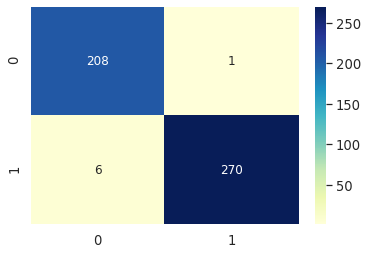

Cardiomegaly


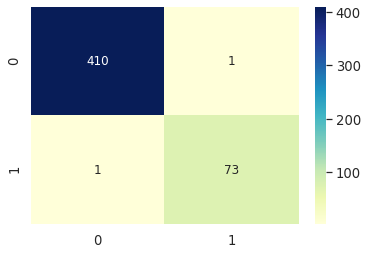

Lung Opacity


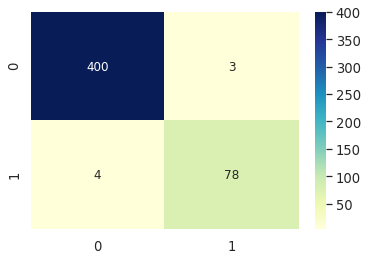

Edema


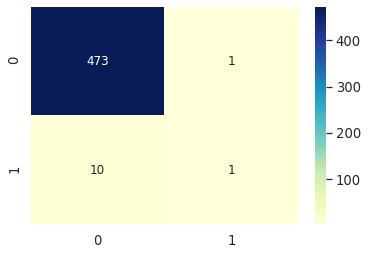

Consolidation


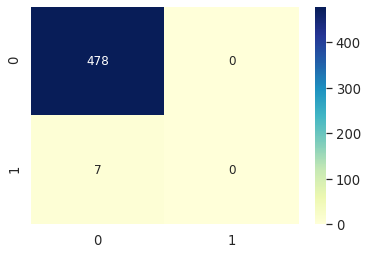

Pneumonia


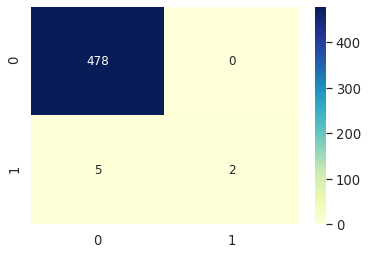

Atelectasis


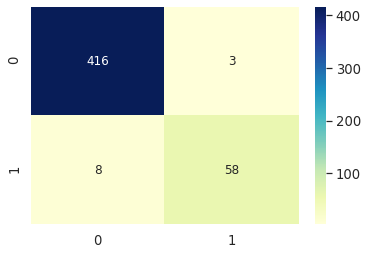

Pneumothorax


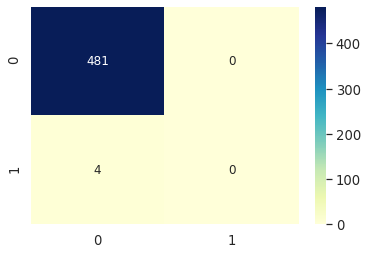

Pleural Effusion


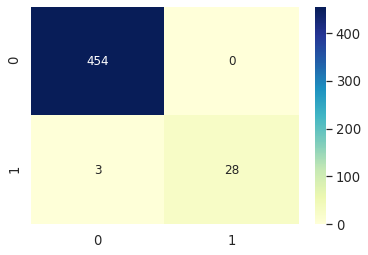

Fracture


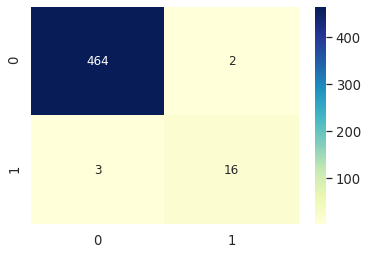

SupportDevices


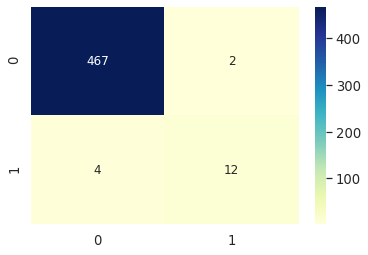

In [10]:
cms = multilabel_confusion_matrix(y_true, y_pred)
def plot_hm(label, conMat):

    df_cm = pd.DataFrame(conMat, range(2), range(2))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.2) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="YlGnBu", fmt="d") # font size
    plt.show()

for cm,label in zip(cms, labels):
    print(label)
#     print(cm)
    plot_hm(label, cm)

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       276
           1       0.99      0.99      0.99        74
           2       0.96      0.95      0.96        82
           3       0.50      0.09      0.15        11
           4       0.00      0.00      0.00         7
           5       1.00      0.29      0.44         7
           6       0.95      0.88      0.91        66
           7       0.00      0.00      0.00         4
           8       1.00      0.90      0.95        31
           9       0.89      0.84      0.86        19
          10       0.86      0.75      0.80        16

   micro avg       0.98      0.91      0.94       593
   macro avg       0.74      0.61      0.64       593
weighted avg       0.95      0.91      0.92       593
 samples avg       0.96      0.94      0.94       593



/local/pkg/python/root-python-3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/pkg/python/root-python-3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Hugging Face implementation

In [ ]:
# from transformers import BertTokenizer, BertForSequenceClassification
# import torch

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
# labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
# outputs = model(input_ids, labels=labels)

# loss, logits = outputs[:2]

In [ ]:
# # From Transformers: https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertForSequenceClassification
# from torch.nn import BCEWithLogitsLoss
# class BertForMultiLabelClassification(BertPreTrainedModel):
#     def __init__(self, config):
#         super().__init__(config)
#         self.num_labels = config.num_labels

#         self.bert = BertModel(config)
#         self.dropout = nn.Dropout(config.hidden_dropout_prob)
#         self.classifier = nn.Linear(config.hidden_size, config.num_labels)

#         self.init_weights()

# [docs]
#     @add_start_docstrings_to_callable(BERT_INPUTS_DOCSTRING.format("(batch_size, sequence_length)"))
#     def forward(
#         self,
#         input_ids=None,
#         attention_mask=None,
#         token_type_ids=None,
#         position_ids=None,
#         head_mask=None,
#         inputs_embeds=None,
#         labels=None,
#     ):


#         outputs = self.bert(
#             input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids,
#             position_ids=position_ids,
#             head_mask=head_mask,
#             inputs_embeds=inputs_embeds,
#         )

#         pooled_output = outputs[1]

#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)

#         outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

#         if labels is not None:
#             if self.num_labels == 1:
#                 #  We are doing regression
#                 loss_fct = MSELoss()
#                 loss = loss_fct(logits.view(-1), labels.view(-1))
#             else:
# #                 loss_fct = CrossEntropyLoss()
#                 loss_fct = BCEWithLogitsLoss()
#                 loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
#             outputs = (loss,) + outputs

#         return outputs  # (loss), logits, (hidden_states), (attentions)